# IMAGE SEGMENTATION WITH TENSORFLOW

This notebook shows how to use Tensorflow to create and train a neural network using the [U-net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/). We will be implementing binary image segmentation on a very simple data set.

## Another 'Getting Started'

This part just tries to explain Tensorflow basics with a few adaptations to the original [tutorial](https://www.tensorflow.org/get_started/get_started). If you are comfortable with it or not interested skip to the next section but even then, you might want to check a few of the links in this section.

Basically:
- The building blocks are called [tensors](https://www.tensorflow.org/programmers_guide/dims_types). Tensors get multiplied and added with other tensors to define your loss tensor and then a gradient descent operator magically creates your prediction tensor. 
    - The tensors are just containers for the data, they do __not__ really contain the data.     
    *Maybe compare this to C pointers: After you have allocated a pointer (created your [tensor variable](https://www.tensorflow.org/api_docs/python/tf/Variable)) you know the data's size etc. but there is no data in your pointer (there is some random garbage, but you see my point). First you need to feed some data into the pointer ([tensor variable](https://www.tensorflow.org/api_docs/python/tf/Variable)) in order to be able to work with it.* 
        - Of course, there is more to Tensors and Variables. [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) and [tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) are different objects. Simply, Tensors are the _results_ of Tensorflow operations (but can be the inputs of other operations) whereas Variables (which _is_ a special kind of Tensor) are generally reserved for our network parameters (weights, biases). [Here](https://stackoverflow.com/questions/40866675/implementation-difference-between-tensorflow-variable-and-tensorflow-tensor) is a better explanation from one of the developers.
- Define operations working on these tensors
    - Input tensor => Operation => Output tensor    
    Thus the operation *node*s describe the network. You can create a perceptron or complex structures like [convolutional layers](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) with Tensorflow operations.
- Define a [Session](https://www.tensorflow.org/versions/r0.10/get_started/basic_usage#launching_the_graph_in_a_session).
*Maybe compare this to your C program's run-time environment.*
- [run](https://www.tensorflow.org/api_docs/python/tf/Session#run) the output tensor (or whatever tensor's value you wish to fetch/learn/evaluate) in this session:
    ```python
    sess = tf.Session()
    # create your graph, do the things
    my_output_value = sess.run(my_output_tensor)
    ```
    - But we want to work on some real data, so we will give the network some input data by using the *feed_dict* parameter:
        ```python
        sess = tf.Session()
        my_input_value = # some numpy array, maybe an image
        # create your graph, define the operations on our input
        my_output_value = sess.run(my_output_tensor, feed_dict={the_name_of_my_input_tensor: my_input_value})
        ```

Let's try to write a [simple linear model with Tensorflow](https://www.tensorflow.org/get_started/get_started), just a little bit different than the original one, to show a few things. Starting with our Variables:

In [1]:
import tensorflow as tf

W = tf.Variable([.3], tf.float32)
b = tf.Variable([-.3], tf.float32)
x = tf.Variable([1.0, 2.0, 3.0, 4.0], trainable=False)
y = tf.Variable([0.0, -1.0, -2.0, -3.0], trainable=False)

Notice how we have set initial values to the tf.Variables and also how we have stated that *x* and *y* are not trainable - they are just the inputs (we will talk about this again). Then, our *W*eights, *b*iases and *x* values define our model here:

In [2]:
linear_model = W * x + b

Then we calculate the loss (prediction error) of our model as the distance between the *y* tensor and our *linear_model* tensor. Remember that these tensors are empty  yet, they just define the *loss tensor*:

In [3]:
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas)

To evaluate this _loss_ value, we will need to run our 'network'. As described, we will create a tf.Session object and run (i.e. evaluate) the loss *tensor*. BUT we will need to run an initializer before actually running for the first time. (Do you ever not initialize? Why do we need to initialize with a separate function? I don't know, it is the way it is.)

In [4]:
sess= tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(loss)

23.66

We got an error of 23.66. So let's modify the linear model parameters ourselves by using the *feed_dict* argument and see what happens to our loss:

In [5]:
sess.run(loss, feed_dict={W: [1.0], b: [0.5]})

101.0

In [6]:
sess.run(loss, feed_dict={W: [1.0], b: [-0.5]})

69.0

Let's also try giving our model different inputs:

In [7]:
sess.run(loss, feed_dict={W: [1.0],
                          b: [-0.5],
                          x: [1.0, 2.0, 3.0, 4.0],
                          y: [-2.0, -4.0, -6.0, -8.0]})

241.0

In [8]:
sess.run(loss, feed_dict={W: [1.0], b: [-0.5]})

69.0

So, using the *feed_dict* argument, we can feed the network its inputs, i.e. *x*, *y*, or we can modify the network parameters, i.e. *W*, *b*. This is [good](https://stackoverflow.com/a/37925826).

Note that if you do not feed data to *x* and *y* with *feed_dict*, tensorflow uses the initial values. This means that *feed_dict* just overrides the tensor's value for that run, but it **does not assign** a new value.  

Now, let's define a gradient descent minimizer operation:

In [9]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

We will run this *train* oepration a few times, e.g. 1000. Each time we run it, Tensorflow will modify the variables/tensors leading up to the *loss* tensor. Backtracing our code, those are *squared_deltas*, then *linear_model* and *y*, and lastly our starting variables: *W*, *x* and *b*.

But *x* and *y* shouldn't be there, those are inputs. So how does Tensorflow know only to modify the actual network variables? Because we have defined inputs to be not trainable. In fact, if we did not, Tensorflow would give us an error about float_ref's because gradient descent does not like to work with variables overridden by *feed_dict* as those would now become [non-mutable variables](https://stackoverflow.com/questions/37958706/in-tensorflow-what-is-the-difference-between-a-tensor-that-has-a-type-ending-in?noredirect=1&lq=1).

Let's train now:

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range (1000):
    sess.run(train, {x: [1.0, 2.0, 3.0 , 4.0],
                     y: [0.0, -1.0, -2.0, -3.0]})
curr_W, curr_b, curr_loss  = sess.run([W, b, loss], {x: [1.0, 2.0, 3.0 , 4.0],
                                                     y: [0.0, -1.0, -2.0, -3.0]})
print("W: %s b: %s loss: %s"%(curr_W, curr_b, curr_loss))
# and don't be tardy, close our session at the end
sess.close()

W: [-0.9999969] b: [ 0.99999082] loss: 5.69997e-11


### The catch

To define our input variables we could have also used [tf.placeholder()](https://www.tensorflow.org/programmers_guide/reading_data#feeding). These tensors do not need to have an initial value (a very handy property) and they are already designed for feeding input to the network so no need to state that they are not trainable. They have also some built-in error checking mechanisms (disallows forgetting to feed data or feeding different shape/type of data).

We have not immediately started using *tf.placeholder()* because I wanted to show you that *feed_dict* is the real magic (but placeholders are also cool). So now we will rewrite the code as it should be: 

In [11]:
import tensorflow as tf

W = tf.Variable([.3], tf.float32)
b = tf.Variable([-.3], tf.float32)
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

linear_model = W * x + b

squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas)

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range (1000):
    sess.run(train, {x: [1.0, 2.0, 3.0 , 4.0],
                     y: [0.0, -1.0, -2.0, -3.0]})
curr_W, curr_b, curr_loss  = sess.run([W, b, loss], {x: [1.0, 2.0, 3.0 , 4.0],
                                                     y: [0.0, -1.0, -2.0, -3.0]})
print("W: %s b: %s loss: %s"%(curr_W, curr_b, curr_loss))
# and don't be tardy, close our session at the end
sess.close()

W: [-0.9999969] b: [ 0.99999082] loss: 5.69997e-11


## Our Aim


Now, to the problem of image segmentation: We will start by doing things in a "bad way".

In the end, we would like to end up with a function like:
```python
def my_unet(input_x):
    # we will create our own network with
    # conv2d and max_pool functions
    return logits
```

We also want to incorporate the Tensorflow goodies such as the [variable scope](https://www.tensorflow.org/programmers_guide/variable_scope) and [threading](https://www.tensorflow.org/programmers_guide/threading_and_queues) into our code. Why?
* It looks nice.
* Everyone does it so we have to understand what is happening if we are to read their code.
* You might not have enough memory to load all of your data at once so you may need an [input pipeline](https://www.tensorflow.org/programmers_guide/reading_data#creating_threads_to_prefetch_using_queuerunner_objects) with which you gradually load the data.

After the training, we might wish to use the simple [feed_dict](https://www.tensorflow.org/programmers_guide/reading_data#feeding) scheme to showcase a few results without the hussle of queues & threads, thus we want our network to accept [both the input pipeline and feed_dict inputs](https://stackoverflow.com/questions/37581671/how-to-mix-queue-based-and-feed-based-input-in-tensorflow).

## Initial Steps

These commands import the required libraries i.e. tensorflow and numpy. matplotlib _inline_ is for displaying the images.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

[tf_unet](https://github.com/jakeret/tf_unet) is a python library and also has been the starting point of this notebook. At this time, we will be borrowing its random image generator to create our image data. [Install](http://tf-unet.readthedocs.io/en/latest/installation.html) it and then:

In [13]:
from tf_unet import image_gen

In the next few cells we will be creating (and displaying) two images:
* The original image,
* Corresponding binary segmentation mask i.e. what our network's output _should_ be after training.

U-Net architecture utilizes [2x2 max-pooling](http://cs231n.github.io/convolutional-networks/#pool). This means that we will be downsampling the data (i.e. halving its size) a few times. Choosing the image size as $2^{n}$ will let us avoid potential integer division problems.

In [14]:
nx = 512
ny = 512

Our generator will create images containing five (_cnt=5_) random sized disks at random positions in the image.

In [15]:
generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=5)

And finally, create and display an example image and its masks (first mask's object of interest is the background, second's is the disks):

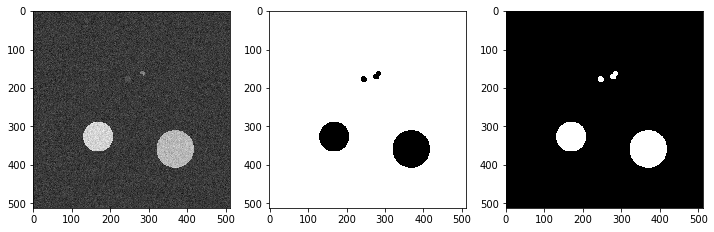

In [16]:
x_test, y_test = generator(1)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], cmap="gray")
ax[1].imshow(y_test[0,...,0], cmap="gray")
ax[2].imshow(y_test[0,...,1], cmap="gray")

## Bad Way To Do It

So for now, We will try to create a 2 layer down 1 layer up U-Net. Simple, but it will make a point.

We start as usual, define our placeholders for the training set (together with the ground truth). Nice thing about placheolders is that you do not need to specify their shape - but as a good practice, we choose to state that these are 4 dimensional tensors (stack of images). We also state that our data consist of single channel images and ground truth consist of two channel images (one channel per segmentation class. i.e. the background and the disks).

In [17]:
sess = tf.Session()
input_x = tf.placeholder(tf.float32, [None, None, None, 1])
input_y = tf.placeholder(tf.float32, [None, None, None, 2])

Our first two layers are convolutional layers according to the [U-Net description](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

We will choose these convolutional layer's output depth (*features_l1*) as 16 and the [receptive field](http://neuralnetworksanddeeplearning.com/chap6.html#introducing_convolutional_networks) as [3, 3], because [why not](https://www.quora.com/How-can-I-decide-the-kernel-size-output-maps-and-layers-of-CNN)? Our input is a single channel (i.e. grayscale) image, so our convolutional mask size ends up as [3, 3, 1, 16]. If you haven't yet, check the convolutional layer in action (as an animation) [here](https://cs231n.github.io/convolutional-networks/#conv).

For two conv-layers we create two pairs of bias and weight variables. Note that the first kernel/filter has a size of [3, 3, 1, 16] while the second one has [3, 3, 16 , 16] (second one's input depth is 16, i.e. same as the output depth of the first one) . Our weights are random variables with a standard deviation calculated as described [here](http://cs231n.github.io/neural-networks-2/#init).

In [18]:
features_l1 = 16
stddev_l1 = np.sqrt(2.0/ (3*3*features_l1))

l1_w1 = tf.Variable(tf.truncated_normal(shape=[3 ,3, 1, features_l1], stddev=stddev_l1))
l1_w2 = tf.Variable(tf.truncated_normal(shape=[3 ,3, features_l1, features_l1], stddev=stddev_l1))
l1_b1 = l1_b2 = tf.Variable(tf.constant(0.1, shape=[features_l1]))

Create our first 'contraction' layer using these kernel variables and [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d), [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu) and [tf.nn.max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool).

In [19]:
l1_conv1_func = tf.nn.conv2d(input_x, 
                             l1_w1, 
                             strides=[1, 1, 1, 1], 
                             padding='SAME')
l1_conv1 = tf.nn.relu(l1_conv1_func + l1_b1)
l1_conv2_func = tf.nn.conv2d(l1_conv1, 
                             l1_w2, 
                             strides=[1, 1, 1, 1], 
                             padding='SAME')
l1_conv2 = tf.nn.relu(l1_conv2_func + l1_b2)
l1_pool = tf.nn.max_pool(l1_conv2, 
                         ksize=[1, 2, 2, 1], 
                         strides=[1, 2, 2, 1], 
                         padding='SAME')

*strides* parameter state that our kernel/filter/receptive field moves by one pixel in each step (like the [animation](https://cs231n.github.io/convolutional-networks/#conv) mentioned above) and *ksize* (together with the corresponding *strides*) parameter states this is 2x2 pooling. *padding* is chosen as 'SAME' intentionally - if it is 'VALID' image size gets smaller at each layer so your final output image size is smaller than your ground truth size. We would need to crop the ground truth image to that smaller size. Not very hard but makes things more complicated.

Our second 'contraction' layer repeats the same pattern, this time with increased filter depth. Note the kernel sizes (and the lack of pooling as this is the final 'contraction' layer before the 'expansion' layers, as described in the [original paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)).

In [20]:
features_l2 = 32
stddev_l2 = np.sqrt(2.0/ (3*3*features_l2))

l2_w1 = tf.Variable(tf.truncated_normal(shape=[3 ,3, features_l1, features_l2], stddev=stddev_l2))
l2_w2 = tf.Variable(tf.truncated_normal(shape=[3 ,3, features_l2, features_l2], stddev=stddev_l2))
l2_b1 = l2_b2 = tf.Variable(tf.constant(0.1, shape=[features_l2]))

l2_conv1_func = tf.nn.conv2d(l1_pool, 
                             l2_w1, 
                             strides=[1, 1, 1, 1], 
                             padding='SAME')
l2_conv1 = tf.nn.relu(l2_conv1_func + l2_b1)
l2_conv2_func = tf.nn.conv2d(l2_conv1, 
                             l2_w2, 
                             strides=[1, 1, 1, 1], 
                             padding='SAME')
l2_conv2 = tf.nn.relu(l2_conv2_func + l2_b2)

Now we will implement the 'expansion' layer. While we can create most image-domain architectures by concatenating [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) layers with [tf.nn.max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool), for U-net, we also need the [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose) layers, which can be thought of as upsampling (thus sometimes called upconvolution). A good explanation of what it does can be found [here](http://cs231n.stanford.edu/slides/2016/winter1516_lecture13.pdf), slides 46 to 59.

This layer's input is the output of the previous 'contraction' layer. i.e. *l2_conv2*.

In [21]:
features_up = 32
stddev_up = np.sqrt(2.0/ (3*3*features_up))

upconv_w = tf.Variable(tf.truncated_normal(shape=[2, 2, features_up//2, features_up], stddev=stddev_up)) #why just decrease the depth? why not decrease with another conv layer? what is happening here?
upconv_b = tf.Variable(tf.constant(0.1, shape=[features_up//2]))
upconv_input_shape = tf.shape(l2_conv2)
upconv_output_shape = tf.stack([upconv_input_shape[0], 
                                upconv_input_shape[1]*2, 
                                upconv_input_shape[2]*2, 
                                upconv_input_shape[3]//2])
upconv_layer_func = tf.nn.conv2d_transpose(l2_conv2, 
                                           upconv_w, 
                                           upconv_output_shape, 
                                           strides=[1, 2, 2, 1], 
                                           padding='SAME')
upconv_layer = tf.nn.relu(upconv_layer_func + upconv_b)

Note how the *upconv_w* variable's shape, i.e. the *conv2d_transpose* operation's kernel, is [2, 2, 16, 32]. First, we are upsampling by 2, hence the [2, 2] receptive field. The dimensional ordering is also different, i.e. kernel input has depth 32 and output is 16 (if this was *conv2d* operation the kernel's shape would be [size, size, input_depth, output_depth]). [At the time of this writing](https://github.com/tensorflow/tensorflow/issues/2118), we also need to calculate the output shape of the *conv2d_transpose* operation.

Then we concatenate ([tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat)) this 'upsampled' result with the output of the **first** contraction layer, i.e. *l1_conv2*

In [22]:
upconv_concat = tf.concat([l1_conv2, upconv_layer], 3)

... and continue with our usual pattern of two successive [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) layers. Note that there is no *pooling* in the expansion layers, also note the decrease in the field depth (32 to 16).

In [23]:
up_l1_w1 = tf.Variable(tf.truncated_normal(shape=[3 ,3, features_up, features_up//2], stddev=stddev_up))
up_l1_w2 = tf.Variable(tf.truncated_normal(shape=[3 ,3, features_up//2, features_up//2], stddev=stddev_up))
up_l1_b1 = up_l1_b2 = tf.Variable(tf.constant(0.1, shape=[features_up//2]))

up_l1_conv1_func = tf.nn.conv2d(upconv_concat, 
                                up_l1_w1, 
                                strides=[1, 1, 1, 1], 
                                padding='SAME')
up_l1_conv1 = tf.nn.relu(up_l1_conv1_func + up_l1_b1)
up_l1_conv2_func = tf.nn.conv2d(up_l1_conv1, 
                                up_l1_w2, 
                                strides=[1, 1, 1, 1], 
                                padding='SAME')
up_l1_conv2 = tf.nn.relu(up_l1_conv2_func + up_l1_b2)

Finally we add a fully connected layer for softmax. Note the shape of the kernel, i.e. [1, 1, 16, 2]. This kernel passes over each *pixel* of depth 16 and creates 2 values, i.e. background and disk class values (not exactly probabilities yet, but an indicator of probabilities).

In [24]:
stddev_out = np.sqrt(2.0/ (3*3*features_l1))
output_w = tf.Variable(tf.truncated_normal(shape=[1 ,1, features_l1, 2], stddev=stddev_out))
output_b = tf.Variable(tf.constant(0.1, shape=[2]))
output_func = tf.nn.conv2d(up_l1_conv2, 
                           output_w, 
                           strides=[1, 1, 1, 1], 
                           padding='SAME')
output = tf.nn.relu(output_func + output_b)

... then flatten and [tf.nn.softmax_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) to define the *loss*:

In [25]:
logits = output
labels = input_y
flat_logits = tf.reshape(logits, [-1, 2])
flat_labels = tf.reshape(labels, [-1, 2])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels))

I see Adam optimizer even more frequently than gradient descent in Kaggle competitions so we will use [that](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer):

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=loss)

At last, we are ready to train our network. Remember to initialize the variables:

In [27]:
sess.run(tf.global_variables_initializer())

Let's run a forward run to see that everything works.

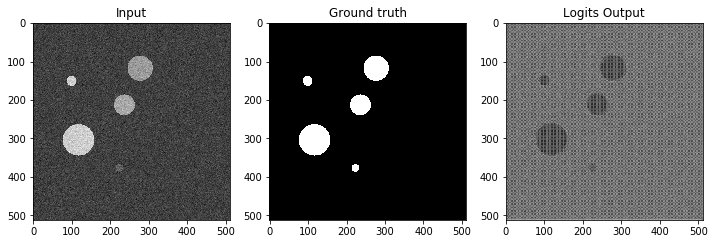

In [28]:
x_test, y_test = generator(1)
out = sess.run(logits, feed_dict={input_x: x_test,
                                  input_y: y_test,})
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], cmap="gray")
ax[1].imshow(y_test[0,...,1], cmap="gray")
ax[2].imshow(out[0,...,1], cmap="gray")
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Logits Output")

We got no errors, and you **may** see that our network output follows the input. Our weight variables are small and randomly distributed i.e. their collective effect **may** not have a significant direction yet so our output **may** still resemble the input image.

By the way, before really training your network, I suggest overfitting to a single input image as it is easier to notice and correct mistakes that way.
- Initially I forgot the paranthesis in my stddev calculation and inserted a huge *stddev* for our weight variables' randomness at each layer. Try and see what happens if you set the stddev=(2.0/ 3\*3\*16) for each layer. I would appreciate it if you can explain *why* the logits becomes more and more like a checkerboard. Also if you change the stddev, the checkerboard tiles' size change. If you also omit the conv2d_transpose and use [basic resizing](tf.image.resize_images) this checkerboard effect disappears so it is related to that layer. What is happening here?

But let's just train our network now. We will just display a channel of our logits output. It is a probabilistic result (i.e. softmax) so not exactly a classification yet but gives us an idea about the performance of the network.

Iter loss is  0.709505
Iter loss is  0.287771
Iter loss is  0.21957
Iter loss is  0.117125
Iter loss is  0.0495677
Iter loss is  0.222412
Iter loss is  0.0832932
Iter loss is  0.0571267
Iter loss is  0.0519227
Iter loss is  0.0754356
Iter loss is  0.182324
Iter loss is  0.0542566
Iter loss is  0.111829
Iter loss is  0.0573693
Iter loss is  0.0309855
Iter loss is  0.232443
Iter loss is  0.0625776
Iter loss is  0.125648
Iter loss is  0.060022
Iter loss is  0.0247394


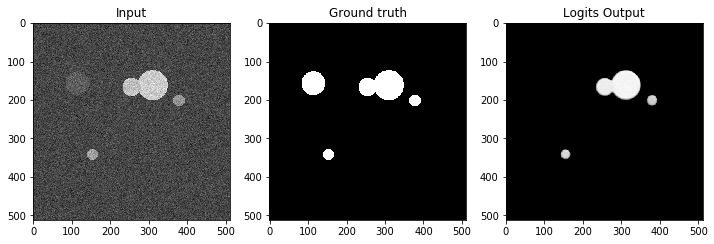

In [29]:
for step in range(400):
    x_test, y_test = generator(1)
    _,iter_loss, out=sess.run((optimizer,loss, logits), feed_dict={input_x: x_test,
                                     input_y: y_test,})
    if step%20==0:
        print("Iter loss is ", iter_loss)
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], cmap="gray")
ax[1].imshow(y_test[0,...,1], cmap="gray")
ax[2].imshow(out[0,...,1], cmap="gray")
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Logits Output")

Now we take the exponential of these predictions, calculate the ratio of the channels for each pixel and create a prediction tensor where the pixel values of the 0<sup>th</sup> channel is the probability that the input pixel belongs to the first class (and 1<sup>st</sup> channel to the second class). We assert that if a 1<sup>st</sup> channel pixel's value in the prediction tensor is above 0.5, it belongs to our circle class, and display it.

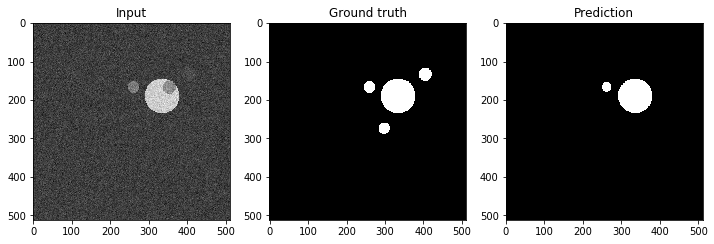

In [30]:
exponential_map = tf.exp(logits)
sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(logits)[3]]))
predicter = tf.div(exponential_map,tensor_sum_exp)

x_test, y_test = generator(1)
prediction = sess.run(predicter, feed_dict={input_x: x_test,
                                            input_y: y_test})
mask = prediction[0,:,:,1] > 0.5
fig, ax= plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,1], cmap='gray')
ax[2].imshow(mask, cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")

Not that bad for such a simple network. Let's close this session now, and create a better network next.

In [31]:
sess.close()

## A Better Way

It took a lot of lines to write our network. And it is literally the smallest U-Net possible. Also, the variable and layer names were hard to follow - if we wanted to increase our network size, it would be even harder.

To solve these problems, we will rewrite (and expand) our network using our own functions as well as utilizing the [Variable Scope](https://www.tensorflow.org/programmers_guide/variable_scope) mechanism of Tensorflow.

Any U-Net consists of 'contraction' and 'expansion' layers culminating in a fully connected layer. But these layers also consist of *conv2d*s and *conv2d_transpose*s.

We will start with writing our own conv2d function:

In [32]:
def conv2d(input_x, kernel_shape, bias_shape, padding, dropout_keep_prob):
    
    stddev = np.sqrt(2.0 / (kernel_shape[0]*kernel_shape[1]*kernel_shape[2]*kernel_shape[3]))    
    weights = tf.get_variable("weights", kernel_shape, 
                              initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    biases = tf.get_variable("biases", bias_shape, 
                             initializer=tf.constant_initializer(0.1))
    conv = tf.nn.conv2d(input_x, weights, strides=[1,1,1,1], padding=padding)   
    relu = tf.nn.relu(conv + biases)
       
    return tf.nn.dropout(relu, dropout_keep_prob)

This function builds upon [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) by creating its own kernel. We define the our kernel parameters using the [tf.get_variable](https://www.tensorflow.org/api_docs/python/tf/get_variable) instead of [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable). Note how we do not really initialize the variable but point it to an initializer.

Later, we will call this *conv2d* function under a [scope](https://www.tensorflow.org/programmers_guide/variable_scope) name, e.g. *hidden_conv_layer*. Then our *weight* variable will be created under that scope and Tensorflow will name it as *hidden_conv_layer/weight* automatically. Less work for us and more readable code.

I have also added a [dropout operation](https://www.tensorflow.org/api_docs/python/tf/nn/dropout). We create a very small data set but also a small number of parameters so overfitting may not be a problem here but we will [just use it](https://www.reddit.com/r/MachineLearning/comments/42nnpe/why_do_i_never_see_dropout_applied_in/).

Similarly we create our *upconv2d* and *fully_connected_layer* functions.

In [33]:
def upconv2d(input_x, kernel_shape, bias_shape, padding, dropout_keep_prob=1.0):
    
    stddev = np.sqrt(2.0 / (kernel_shape[0]*kernel_shape[1]*kernel_shape[2]*kernel_shape[3]))    
    weights = tf.get_variable("weights", kernel_shape, dtype=tf.float32, 
                              initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    biases = tf.get_variable("biases", bias_shape, 
                             initializer=tf.constant_initializer(0.1))
    input_shape = tf.shape(input_x)
    output_shape = [input_shape[0], 
                    input_shape[1]*2, 
                    input_shape[2]*2, 
                    kernel_shape[2]] #kernel_shape[2] is the output_channels argument of the filter/weights for tf.nn.conv2d_transpose()
    upconv = tf.nn.conv2d_transpose(input_x, 
                                    weights, 
                                    output_shape=output_shape, 
                                    strides=[1, 2, 2, 1], 
                                    padding=padding)
    relu = tf.nn.relu(upconv + biases)
    
    return tf.nn.dropout(relu, dropout_keep_prob)

In [34]:
def fully_connected_layer(input_x, output_channels, input_channels, padding, dropout_keep_prob=1.0):
    
    stddev = np.sqrt(2.0 / (1*1*input_channels*output_channels))    
    weights = tf.get_variable("weights", 
                              [1, 1, input_channels, output_channels], 
                              dtype=tf.float32, 
                              initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    biases = tf.get_variable("biases", 
                             output_channels, 
                             initializer=tf.constant_initializer(0.1))
    conv = tf.nn.conv2d(input_x, weights, strides=[1,1,1,1], padding=padding)   
    relu = tf.nn.relu(conv + biases)
       
    return tf.nn.dropout(relu, dropout_keep_prob)

We could use these functions to create our network but lets add a few more layer of abstraction. We will create our 'contraction' layer with the *conv_layer* function and 'expansion' layer with the *upconv_layer* function.

Note how we use the [tf.variable_scope](https://www.tensorflow.org/programmers_guide/variable_scope#variable_scope_example). As decribed previously, *conv2d* function is called under the *hidden_conv_layer* scope such that any variables created by [tf.get_variable](https://www.tensorflow.org/programmers_guide/variable_scope#understanding_tfget_variable) are named by appending the scope name as a prefix. e.g. *hidden_conv_layer/biases* or *output_conv_layer/biases*. But it does not matter for variables created by other means than [tf.get_variable](https://www.tensorflow.org/programmers_guide/variable_scope#understanding_tfget_variable), e.g. *kernel_shape* and *bias_shape*.

In [35]:
def conv_layer(input_x, filter_size, output_channels, input_channels, padding, dropout_keep_prob):
    
    kernel_shape = [filter_size, filter_size, input_channels, output_channels]
    bias_shape = [output_channels]
    
    with tf.variable_scope("hidden_conv_layer"):    
        hidden_conv_layer = conv2d(input_x, 
                                   kernel_shape, 
                                   bias_shape,
                                   padding='SAME', 
                                   dropout_keep_prob=dropout_keep_prob)    
    kernel_shape = [filter_size, filter_size, output_channels, output_channels]
    bias_shape = [output_channels]       
    
    with tf.variable_scope("output_conv_layer"):
        output_conv_layer = conv2d(hidden_conv_layer, 
                                   kernel_shape, 
                                   bias_shape,
                                   padding='SAME', 
                                   dropout_keep_prob=dropout_keep_prob)
    
    return output_conv_layer

In [36]:
def upconv_layer(input_x, concat_input, filter_size, output_channels, input_channels, padding, dropout_keep_prob):
    with tf.variable_scope("hidden_upconv_layer"):
        kernel_shape = [filter_size, filter_size, output_channels, input_channels]
        bias_shape = [output_channels]        
        hidden_upconv_layer1 = upconv2d(input_x, 
                                        kernel_shape, 
                                        bias_shape, 
                                        padding= padding, 
                                        dropout_keep_prob=1.0)
    with tf.variable_scope("hidden_conv_layer"):
        # we will concat with a down conv layer with same depth/channels and use the concatenated tensor as input:
        hidden_conv_layer_input_channels = output_channels*2 
        kernel_shape = [filter_size, filter_size, hidden_conv_layer_input_channels, output_channels]
        bias_shape = [output_channels]        
        concatenated_layer = tf.concat([concat_input, hidden_upconv_layer1], 3)
        hidden_conv_layer = conv2d(concatenated_layer, 
                                   kernel_shape, 
                                   bias_shape, 
                                   padding=padding, 
                                   dropout_keep_prob= dropout_keep_prob)
    with tf.variable_scope("output_conv_layer"):
        kernel_shape = [filter_size, filter_size, output_channels, output_channels]
        bias_shape = [output_channels]
        output_conv_layer = conv2d(hidden_conv_layer, 
                                   kernel_shape, 
                                   bias_shape, 
                                   padding= padding, 
                                   dropout_keep_prob= dropout_keep_prob)
    return output_conv_layer

Now we can have a far more readable code describing our network. Note the *concat_input* arguments of the *upconv_layer*s:

In [37]:
def my_unet(input_x, dropout_keep_prob):
    filter_size = 3
    output_classes = 2 # binary segmentation
    input_channels = 1
    pool_size = 2 # max_pooling to halve the image size    
    
    features = 16
            
    with tf.variable_scope("down_layer1"):
        down_layer1 = conv_layer(input_x, 
                                 filter_size, 
                                 output_channels= features, 
                                 input_channels= input_channels, 
                                 padding='SAME', 
                                 dropout_keep_prob=0.75)
        pooled_layer1 = tf.nn.max_pool(down_layer1, 
                                       ksize=[1, pool_size, pool_size, 1], 
                                       strides=[1, pool_size, pool_size, 1], 
                                       padding='SAME')
    with tf.variable_scope("down_layer2"):
        down_layer2 = conv_layer(pooled_layer1, 
                                 filter_size, 
                                 input_channels= features, 
                                 output_channels= features*2, 
                                 padding='SAME', 
                                 dropout_keep_prob=0.75)
        pooled_layer2 = tf.nn.max_pool(down_layer2, 
                                       ksize=[1, pool_size, pool_size, 1], 
                                       strides=[1, pool_size, pool_size, 1], 
                                       padding='SAME')
    with tf.variable_scope("down_layer3"):
        down_layer3 = conv_layer(pooled_layer2, 
                                 filter_size, 
                                 input_channels= features*2, 
                                 output_channels= features*4, 
                                 padding='SAME', 
                                 dropout_keep_prob=0.75)
    with tf.variable_scope("up_layer1"):
        up_layer1 = upconv_layer(down_layer3, 
                                 concat_input= down_layer2, 
                                 filter_size= filter_size, 
                                 padding="SAME",
                                 output_channels= features*2, 
                                 input_channels= features*4, 
                                 dropout_keep_prob=0.75)
    with tf.variable_scope("up_layer2"):
        up_layer2 = upconv_layer(up_layer1, 
                                 concat_input= down_layer1, 
                                 filter_size=filter_size, 
                                 padding="SAME",
                                 output_channels= features, 
                                 input_channels= features*2, 
                                 dropout_keep_prob=0.75)
    with tf.variable_scope("output_layer"):
        output_layer = fully_connected_layer(up_layer2, 
                                             output_channels= output_classes, 
                                             input_channels= features,
                                             padding='SAME')
        
    return output_layer

This network is still a small one, what would happen if we wished to create more layers? In the [tf_net](https://github.com/jakeret/tf_unet) library, the author have chosen to create the layers using two for loops for 'contraction' and 'expansion' layers. We could do the same thing using our *conv_layer* and *upconv_layer* functions but I believe readability is more important and we are not trying to create a variable-sized network generating library anyway.

As usual, we will define our *loss* tensor and *optimizer* operation, then initialize before running the network for the first time. Note that we are creating our network inside the *net* scope - we did not need to do this as all the variables inside the *my_unet* function would already be created inside their own layer scopes but giving a name to the network is better, I think.

In [38]:
sess = tf.Session()
input_x = tf.placeholder(tf.float32, [None, None, None, 1])
input_y = tf.placeholder(tf.float32, [None, None, None, 2])
dropout_keep_prob = tf.placeholder(tf.float32)

with tf.variable_scope("net") as scope:
    logits = my_unet(input_x, dropout_keep_prob)

labels = input_y
flat_logits = tf.reshape(logits, [-1, 2])
flat_labels = tf.reshape(labels, [-1, 2])

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=loss)
    
sess.run(tf.global_variables_initializer())

It is time to train. We will train with more data (more steps) becuase our network has more parameters to optimize. Also note how the *dropout_keep_prob* is equal to 1 for creating a logits output, i.e. we want all of our network to affect the outcome, they are already trained.

iter loss =  0.771926
iter loss =  0.219579
iter loss =  0.183131
iter loss =  0.132396
iter loss =  0.183993
iter loss =  0.138103
iter loss =  0.161647
iter loss =  0.0541205
iter loss =  0.0828025
iter loss =  0.0684175
iter loss =  0.0178759
iter loss =  0.0414109
iter loss =  0.0979303
iter loss =  0.04956
iter loss =  0.150114
iter loss =  0.0914247
iter loss =  0.0535857
iter loss =  0.0210522
iter loss =  0.0739705
iter loss =  0.04361


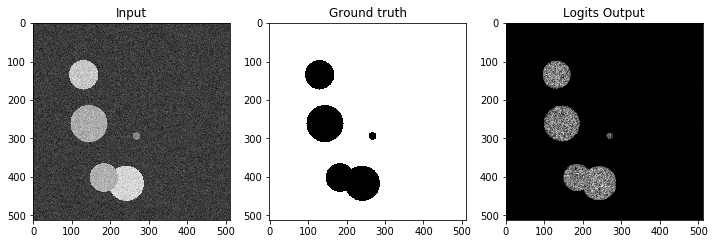

In [39]:
for step in range(400):
    x_test, y_test = generator(1)
    _, iter_loss = sess.run((optimizer, loss), feed_dict={input_x: x_test,
                                                          input_y: y_test,
                                                          dropout_keep_prob: 0.75})
    if step%20 == 0:
        print("iter loss = ", iter_loss)
x = sess.run(logits, feed_dict={input_x: x_test, 
                                input_y: y_test,
                                dropout_keep_prob: 1})
fig, ax= plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,0], cmap='gray')
ax[2].imshow(x[0,:,:,1], cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Logits Output")

After the training, check if our network works as expected:

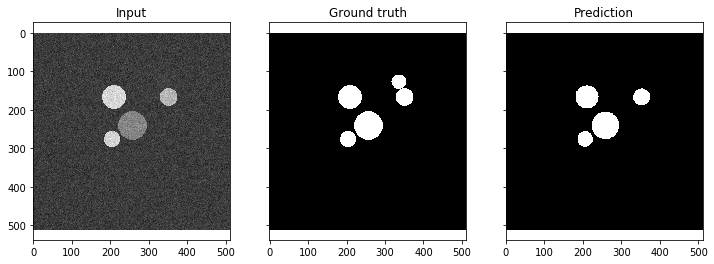

In [40]:
exponential_map = tf.exp(logits)
sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(logits)[3]]))
predicter = tf.div(exponential_map,tensor_sum_exp)

x_test, y_test = generator(1)
prediction = sess.run(predicter, feed_dict={input_x: x_test,
                                            input_y: y_test,
                                            dropout_keep_prob: 1})
mask = prediction[0,:,:,1] > 0.5
fig, ax= plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,1], cmap='gray')
ax[2].imshow(mask, cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")

## Queues and  *feed_dict*

The queue structure is the way to train with data too big for memory. First let's assume our generator is not generating but instead reading an image from our data set.
- With this assumption, we would need to read a different image at each step, but for now let's just say we can do that. We could always generate a random number with numpy, append that to the filename string and read that. But that is not really an elegant solution. We will do something better using Tensorflow's higher level input pipeline functions a little bit later. 

Here we create a [Tensorflow queue](https://www.tensorflow.org/api_guides/python/io_ops#Queues). I have chosen a [FIFO queue](https://www.tensorflow.org/api_docs/python/tf/FIFOQueue) - it is the simplest one with no other functionality other than being a queue.

In [41]:
queue = tf.FIFOQueue(name="examples", 
                     capacity=800, 
                     dtypes=[tf.float32, tf.float32], 
                     shapes=[(1,512, 512, 1), (1, 512, 512, 2)])

This queue is described as a node in our graph (network). It holds a set of tensors inside. We want to use *enqueue* nodes (operations) to push tensors in and *dequeue* nodes (operations) to fetch tensors out.

OK, nice. Also, see [here](http://ischlag.github.io/2016/11/07/tensorflow-input-pipeline-for-large-datasets/) and [here](https://blog.metaflow.fr/tensorflow-how-to-optimise-your-input-pipeline-with-queues-and-multi-threading-e7c3874157e0) and [here slides 14-18](http://web.stanford.edu/class/cs20si/lectures/slides_09.pdf).

If you have checked the three links I have mentioned above, they either enqueue Tensorflow objects to the queue or fill the queue with many random samples in one step. Now, the cell below is aimed to fill a queue with a single example, such that we overfit and see if everything works as expected.

### Could someone explain this to me, please?

You will see that it does not work as expected. In fact, it fills the queue with randomly generated samples so our network does not overfit i.e. it is trained properly. What is happening here? 

Our *enqueu_op* knows of just an *example* variable which is a tuple of *ndarray*s. How does the *enqueu_op* goes and runs the *generator()* when we run its thread(s)? Is something else happening here?

In [42]:
example = generator(1)
enqueue_op = queue.enqueue(example)
inputs = queue.dequeue_many(1)

### A nice trick

Now, we could use *inputs* (or rather, *inputs[0]*) as an argument to our *my_unet* function. But if we do that, how are we going to feed our network one sample for evaluation? Yes we could create some tf.Variables and then use *feed_dict* to override them but there is a very handy utility to achieve this as explained [here](https://stackoverflow.com/questions/37581671/how-to-mix-queue-based-and-feed-based-input-in-tensorflow).

In [43]:
input_x = tf.placeholder_with_default(inputs[0][0,:,:,:,:], shape=(None, 512,512,1))
input_y = tf.placeholder_with_default(inputs[1][0,:,:,:,:], shape=(None, 512,512,2))

Another bonus of this trick? Our network definition code remains the same as the previous, no-queues-used one:

In [44]:
dropout_keep_prob = tf.placeholder(tf.float32)

with tf.variable_scope("queued_net") as scope:
    
    logits = my_unet(input_x, dropout_keep_prob)
    labels = input_y
    
    flat_logits = tf.reshape(logits, [-1, 2])
    flat_labels = tf.reshape(labels, [-1, 2])

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels))

    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=loss)

Now we train again. Original code [here](https://www.tensorflow.org/programmers_guide/threading_and_queues#queuerunner).

In [45]:
qr = tf.train.QueueRunner(queue, [enqueue_op]*2)

# Launch the graph.
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Create a coordinator, launch the queue runner threads.
coord = tf.train.Coordinator()
enqueue_threads = qr.create_threads(sess, coord=coord, start=True)
# Run the training loop, controlling termination with the coordinator.
for step in range(800):
    if coord.should_stop():
        break
    _, iter_loss = sess.run((optimizer, loss), feed_dict={dropout_keep_prob: 0.75})
    if step%40==0:
        print("iter loss = ", iter_loss)
# When done, ask the threads to stop.
coord.request_stop()
# And wait for them to actually do it.
coord.join(enqueue_threads)

iter loss =  0.657367
iter loss =  0.135534
iter loss =  0.0530781
iter loss =  0.0259347
iter loss =  0.0233706
iter loss =  0.0215592
iter loss =  0.0193866
iter loss =  0.0173691
iter loss =  0.0154453
iter loss =  0.0139367
iter loss =  0.0128155
iter loss =  0.011428
iter loss =  0.010279
iter loss =  0.00936638
iter loss =  0.00858066
iter loss =  0.00789184
iter loss =  0.00712103
iter loss =  0.00655471
iter loss =  0.00597474
iter loss =  0.00543093


And check our results the same way we did before with *feed_dict*, courtesy of [tf.placeholder_with_default](https://www.tensorflow.org/api_docs/python/tf/placeholder_with_default) we used before:

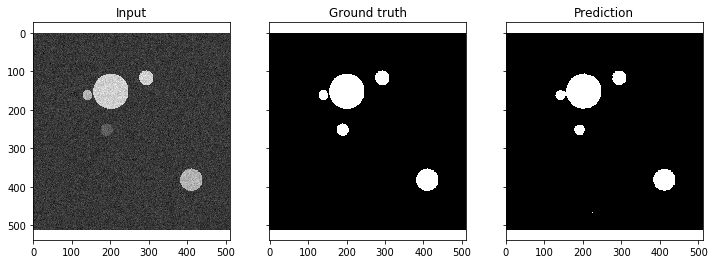

In [46]:
exponential_map = tf.exp(logits)
sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(logits)[3]]))
predicter = tf.div(exponential_map,tensor_sum_exp)

x_test, y_test = generator(1)
prediction = sess.run(predicter, feed_dict={dropout_keep_prob: 1,
                                           input_x: x_test,
                                           input_y: y_test})
mask = prediction[0,:,:,1] > 0.5
fig, ax= plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,1], cmap='gray')
ax[2].imshow(mask, cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")

In [47]:
sess.close()

## Input Pipelines: *TFRecords*

Let's go one more step and try to use [TFRecords](https://www.tensorflow.org/api_guides/python/python_io#tfrecords_format_details) as noted [here](https://www.tensorflow.org/programmers_guide/reading_data#file_formats). We first create and save a few hundred images into a [TFRecords](https://www.tensorflow.org/api_guides/python/python_io#tfrecords_format_details) file.
- If you generate your own data, you can always save your image files using other libraries for later use. </summary>
Scikit-image is a pain to [install](http://scikit-image.org/docs/stable/install.html) if you don't use [anaconda](https://www.continuum.io/downloads). OpenCV is easy to [install](https://pypi.python.org/pypi/opencv-python) and useful for many other things... Sadly, neither of them can read/write 64 bit images. I have included a sample code using OpenCV's xml/yml tools here but this is barely better than using numpy.save(). Then, for example, you could use the *read_data* function instead of the *generator* in the next cell.

    ```python
    import cv2
    import os, shutil

    current_dir = os.getcwd()
    data_dir = os.path.join(current_dir, 'tutorial_data')

    if os.path.isdir(data_dir):
        shutil.rmtree(data_dir)
    os.mkdir(data_dir)

    fs = cv2.FileStorage(os.path.join(data_dir, 'data.yml'), cv2.FILE_STORAGE_WRITE)
    for i in range(800):
        image, masks = generator(1)
        fs.write("image" + str(i), image[0,:,:,0])
        fs.write("background_mask" + str(i), masks[0,:,:,0])
        fs.write("disks_mask" + str(i), masks[0,:,:,1])
    fs.release()

    fs = cv2.FileStorage(os.path.join(data_dir, 'data.yml'), cv2.FILE_STORAGE_READ)

    def read_data(index, fs):
        image = fs.getNode("image" + str(index)).mat().reshape([1, 512, 512, 1])
        back_mask = fs.getNode("background_mask" + str(index)).mat().reshape([1, 512, 512])
        disk_mask = fs.getNode("disks_mask" + str(index)).mat().reshape([1, 512, 512])
        masks = np.stack((back_mask, disk_mask),-1)
        return image, masks
    ```


The good part is TFRecords is the so called standard Tensorflow format. The bad part is that you [cannot](https://github.com/tensorflow/tensorflow/issues/7482) append more data to a TFRecords file. As a result, each time your data set gets bigger (this would **always** happen in a real-life project, I guess), you would need to create a new TFRecords file from scratch. That takes a lot of time if your data is big (isn't this the point?).

Nonetheless, [here](http://planspace.org/20170323-tfrecords_for_humans/) and [here](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/) are two good reads about TFRecords. Borrowing from their code:

In [48]:
import os, shutil

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'tutorial_data')

In [49]:
if os.path.isdir(data_dir):
    shutil.rmtree(data_dir)
os.mkdir(data_dir)

In [50]:
filename = os.path.join(data_dir, "data" + '.tfrecords')

In [51]:
writer = tf.python_io.TFRecordWriter(filename)

for i in range(800):
    sample = generator(1)
    # we reshape our images such that when we read these back, the shapes match the rest of the code
    image = sample[0].reshape([512,512,1])
    masks = sample[1].reshape([512,512,2])
    # convert to string, we are just writing bytes
    image_raw = image.tostring()
    masks_raw = masks.tostring()
    example = tf.train.Example(
        features=tf.train.Features(
          feature={
              'masks': tf.train.Feature(bytes_list=tf.train.BytesList(value=[masks_raw])),
              'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_raw])),
          }))
    writer.write(example.SerializeToString())
writer.close()

What are [features](https://github.com/tensorflow/tensorflow/blob/r1.1/tensorflow/core/example/feature.proto) and [protobufs](https://github.com/tensorflow/tensorflow/blob/r1.1/tensorflow/core/example/example.proto) and how many nested calls are we making and... Yes, I know. It is not really that complicated but the interface is a lttle bit clunky so just copy/paste like everyone. For reference, here is how you read a single example from that file if you want to check that everything is in order:

In [52]:
def read_one_from_TFRecords(filename, data_index):
    data_iterator = tf.python_io.tf_record_iterator(filename)
    i=0
    for our_data in data_iterator:
        example = tf.train.Example()
        example.ParseFromString(our_data)
        image_string = (example.features.feature['image']
                                      .bytes_list
                                      .value[0])
        masks_string = (example.features.feature['masks']
                                      .bytes_list
                                      .value[0])
        returned_image = np.fromstring(image_string, dtype=np.float64).reshape(512,512,1)
        returned_masks = np.fromstring(masks_string, dtype=np.float64).reshape(512,512,2)
        if i==data_index:
            break
        i = i + 1
    return returned_image, returned_masks

Now we are creating our [reader](https://www.tensorflow.org/api_guides/python/io_ops#Readers). If you check that link, you will see that they are basically the same thing, for different file types.

In [53]:
def read_and_decode_TFRecords(filename_queue):    
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'image': tf.FixedLenFeature([], tf.string),
        'masks': tf.FixedLenFeature([], tf.string)
        })
    image = tf.decode_raw(features['image'], tf.float64)
    masks = tf.decode_raw(features['masks'], tf.float64)
    image = tf.reshape(image, [1,512,512,1])
    masks = tf.reshape(masks, [1,512,512,2])
    
    """image, masks = tf.train.shuffle_batch([image, masks],
                                          batch_size=1,
                                          capacity=30,
                                          num_threads=2,
                                          min_after_dequeue=10)"""    
    return image, masks

### Explanations

What did we do here? We have created a [reader](https://www.tensorflow.org/api_guides/python/io_ops#Readers) object and fed its *read()* member-function a queue of filenames. In our case this queue consists of a single *filename="somewhere_in)your_pc/data.tfrerecords"* which contains 800 samples. 

Now, somewhere in that cell, image and masks *tensors* must have been assigned a *dequeue* operation i.e. they must have become a *dequeue* operation/tensor such that when we run our graph in a session later, the data flows as expected. I am guessing it happens in the *reader.read()* operation based on its [description](https://www.tensorflow.org/api_docs/python/tf/ReaderBase#read).

What I understand after checking these [awesome lecture notes](http://web.stanford.edu/class/cs20si/lectures/notes_09.pdf) is that, in general, we should be creating a *queue* containing addresses (filenames, in-file iterators, whatever) to our samples. The *reader.read()* gives us a tensor by *dequeueing* from this queue. Then, if we want to, we use batching (we will talk about this in a few paragraphs).

#### I am not sure but...

This *dequeue* operation needs a *queue* to work on. In other problems involving multiple input files where each sample **is** its own file, we would use a [filename queue producer](https://www.tensorflow.org/api_docs/python/tf/train/string_input_producer) and then a [whole-file-reader](https://www.tensorflow.org/api_docs/python/tf/WholeFileReader) would *dequeue* from that. Checking [this](https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10_input.py) file, I am guessing that [fixed-length-reader](https://www.tensorflow.org/api_docs/python/tf/FixedLengthRecordReader) and similarly our [TFRecordReader](https://www.tensorflow.org/api_docs/python/tf/TFRecordReader) are creating their own *queue*s and iterators to traverse the data files given to them and the *read()* function does the dequeueing as usual.


### Working with a set of images using WholeFileReader

Check this [code](https://gist.github.com/eerwitt/518b0c9564e500b4b50f). I would write a function like this (note that I haven't tested this, mind the typos, mismatches etc.):

```python
def read_and_decode_WholeFiles(filename_queue):
    reader = tf.WholeFileReader()
    _, image_data = reader.read(filename_queue)
    image = tf.image.decode_jpeg(image_data) # or tf.image.decode_png according to your data type
    return image

```
You can generate your filename_queue easily by manipulating strings in python then using the [filename queue producer](https://www.tensorflow.org/api_docs/python/tf/train/string_input_producer) as shown in the first line of [this example code](https://www.tensorflow.org/programmers_guide/reading_data#file_formats#csv_files) found in the documentation.


### Batching

Just uncomment the lines above but do not forget to change 

```python
image = tf.reshape(image, [1,512,512,1])
masks = tf.reshape(masks, [1,512,512,2])
```
into

```python
image = tf.reshape(image, [512,512,1])
masks = tf.reshape(masks, [512,512,2])
```

to avoid size mismatches. And check [this answer](https://stackoverflow.com/questions/41217771/how-does-tf-train-batch-create-a-batch). The [train.batch function family](https://www.tensorflow.org/api_guides/python/io_ops#batching_at_the_end_of_an_input_pipeline) creates yet another queue internally. With batching, after you somehow create your samples, you collect and serve them in batches to your graph. Remember how we have always let the first dimension as *None* while creating our input placeholders? Now we can feed our graph multiple samples at each step (stacked in that first dimension, i.e. the *batch_size* dimension) if we want to.

### And train again...

We create the *image* and *masks* tensors instead of the previously used *example* tuple. 

In [54]:
filename_queue = tf.train.string_input_producer([filename])
image, masks = read_and_decode_TFRecords(filename_queue)

Remember to change the data type to avoid mismatches:

In [55]:
image = tf.cast(image, dtype=tf.float32)
masks = tf.cast(masks, dtype=tf.float32)

Our placeholder trick for evaluation:

In [56]:
input_x = tf.placeholder_with_default(image, shape=(None, 512,512,1))
input_y = tf.placeholder_with_default(masks, shape=(None, 512,512,2))

The usual graph definition:

In [57]:
dropout_keep_prob = tf.placeholder(tf.float32)

with tf.variable_scope("tfrecords_net") as scope:
    
    logits = my_unet(input_x, dropout_keep_prob)
    labels = input_y
    
    flat_logits = tf.reshape(logits, [-1, 2])
    flat_labels = tf.reshape(labels, [-1, 2])

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels))

    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=loss)

Before training note that we have not created any explicit [QueueRunner](https://www.tensorflow.org/programmers_guide/threading_and_queues#queuerunner)s this time. Everything has been handled by *reader*s and *batching*. But we still need to start the threads to run our (now implicit) *dequeue* operations. So instead of [create_threads](https://www.tensorflow.org/api_docs/python/tf/train/QueueRunner#create_threads) we use [start_queue_runners](https://www.tensorflow.org/api_docs/python/tf/train/start_queue_runners) and *coord* those *threads*.

In [58]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess, coord=coord, start=True)

for step in range(400):
    if coord.should_stop():
        break
    _, iter_loss = sess.run((optimizer, loss), feed_dict={dropout_keep_prob: 0.75})
    if step%40==0:
        print("iter loss = ", iter_loss)
coord.request_stop()
coord.join(threads)

iter loss =  0.674807
iter loss =  0.218723
iter loss =  0.0482373
iter loss =  0.100901
iter loss =  0.0660817
iter loss =  0.0375107
iter loss =  0.145161
iter loss =  0.0500671
iter loss =  0.0544098
iter loss =  0.0250337


After training finishes, we test with one sample, as usual:

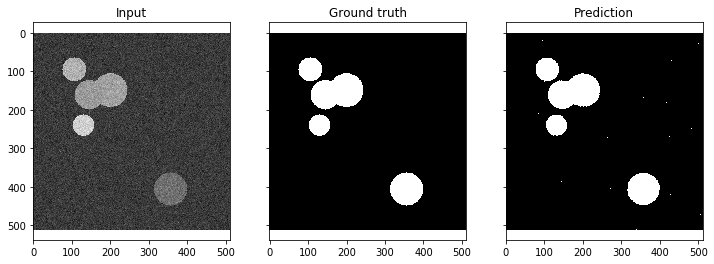

In [59]:
exponential_map = tf.exp(logits)
sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(logits)[3]]))
predicter = tf.div(exponential_map,tensor_sum_exp)

x_test, y_test = generator(1)
prediction = sess.run(predicter, feed_dict={dropout_keep_prob: 1,
                                           input_x: x_test,
                                           input_y: y_test})
mask = prediction[0,:,:,1] > 0.3
fig, ax= plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,1], cmap='gray')
ax[2].imshow(mask, cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")

## Closing comments

First, a question: Why does our *loss* oscillate that much during training?

Next time I will try to add TensorBoard hooks to our graph for monitoring. Maybe in another notebook, this is long enough.